## Feature Engineering

In [22]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing

# Load sample data
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Check a few columns
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Interaction Features

In [23]:
# Create a new interaction feature: total rooms per household
X['AveBedrmsToRooms'] = X['AveBedrms'] / X['AveRooms']

### Binning

In [24]:
# Bin median income into 5 equal-frequency bins
X['IncomeBin'] = pd.qcut(X['MedInc'], q=5, labels=False)

### Log Tranform Skewed Data

In [25]:
X['LogAveOccup'] = np.log1p(X['AveOccup'])  # log(1 + x) to handle zeros

### Polynomial Features (For making linear regression model work with curves)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Simulate non-linear data
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 0.5 * X**2 - 3*X + 4 + np.random.randn(*X.shape) * 2  # True relationship is quadratic

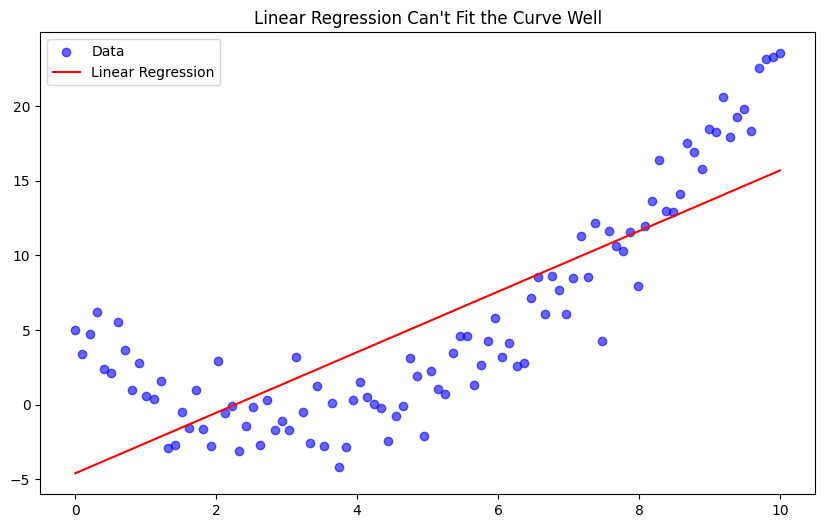

In [27]:
# Fit a straight line
linreg = LinearRegression()
linreg.fit(X, y)
y_pred_linear = linreg.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label="Data")
plt.plot(X, y_pred_linear, color='red', label="Linear Regression")
plt.title("Linear Regression Can't Fit the Curve Well")
plt.legend()
plt.show()

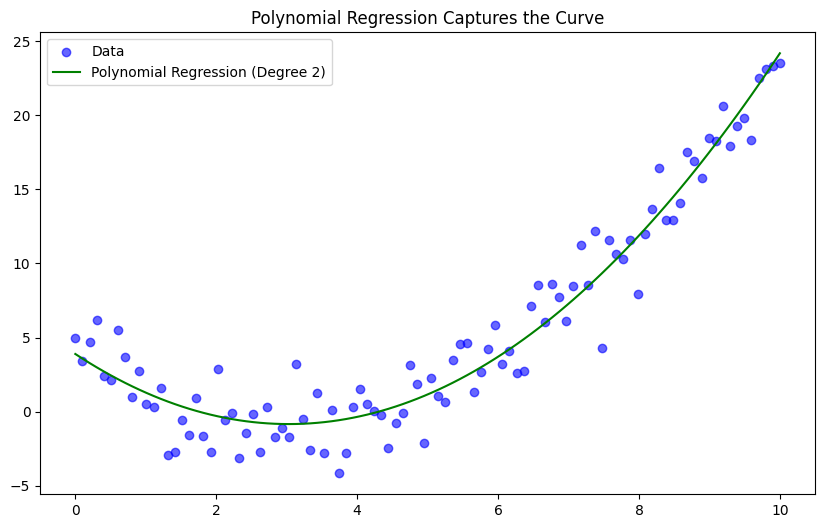

Linear RMSE: 4.307953395112289
Polynomial RMSE: 1.8019974334578452


In [28]:
# Create a pipeline: Polynomial -> Linear Regression
from sklearn.metrics import root_mean_squared_error

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label="Data")
plt.plot(X, y_pred_poly, color='green', label="Polynomial Regression (Degree 2)")
plt.title("Polynomial Regression Captures the Curve")
plt.legend()
plt.show()

# Compare RMSE
print("Linear RMSE:", root_mean_squared_error(y, y_pred_linear))
print("Polynomial RMSE:", root_mean_squared_error(y, y_pred_poly))


## Hyperparameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)

Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Best RMSE: 5.028945275701667


e:\projects\machine-learning\Notebooks\venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(xgb, params, n_iter=10, cv=3, scoring='neg_mean_squared_error')
search.fit(X, y)
print(search.best_params_)

{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


## Scaling and Normalization

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, LabelEncoder
)

# Generate synthetic data
np.random.seed(42)
df = pd.DataFrame({
    'AveRooms': np.random.normal(5, 2, 10),
    'HouseQuality': ['Low', 'Medium', 'High', 'Low', 'Medium', 'High', 'Medium', 'Low', 'High', 'Medium'],
    'Neighborhood': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'C', 'B', 'A']
})

# --- SCALING NUMERIC FEATURE: AveRooms ---

# StandardScaler: centers data around 0 with unit variance
df['AveRooms_Standard'] = StandardScaler().fit_transform(df[['AveRooms']])

# MinMaxScaler: scales all values between 0 and 1
df['AveRooms_MinMax'] = MinMaxScaler().fit_transform(df[['AveRooms']])

# RobustScaler: removes median and scales by IQR
df['AveRooms_Robust'] = RobustScaler().fit_transform(df[['AveRooms']])

# PowerTransformer (Yeo-Johnson): makes data more Gaussian
df['AveRooms_Power'] = PowerTransformer().fit_transform(df[['AveRooms']])

# --- ORDINAL ENCODING ---

# Ordinal feature (HouseQuality): has a meaningful order
ordinal_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['HouseQuality_Ordinal'] = df['HouseQuality'].map(ordinal_map)

# --- NOMINAL ENCODING OPTIONS ---

# Option A: One-hot encoding (good for linear models)
df_onehot = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)

# Option B: Label encoding (good for tree-based models like XGBoost, Random Forest)
le = LabelEncoder()
df['Neighborhood_LabelEncoded'] = le.fit_transform(df['Neighborhood'])

# --- FINAL OUTPUT ---
print("With One-Hot Encoding:")
print(df_onehot.head(), end="\n\n")

print("With Label Encoding:")
print(df[['Neighborhood', 'Neighborhood_LabelEncoded']].head())

# 🔧 GENERAL SCALING STRATEGY:

# Feature Pattern           → Recommended Scaler      → Reason
# -------------------------------------------------------------
# Wide range / outliers     → RobustScaler            → Resilient to outliers
# Moderate variance         → StandardScaler          → Normalizes to N(0,1)
# Bounded / known range     → MinMaxScaler            → Good for [0, 1] scaling
# Categorical (numeric)     → Leave as-is or OneHot   → Use if encoded or for IDs

   AveRooms HouseQuality  AveRooms_Standard  AveRooms_MinMax  AveRooms_Robust  \
0  5.993428          Low           0.070933         0.471613        -0.024189   
1  4.723471       Medium          -0.854819         0.161669        -0.694233   
2  6.295377         High           0.291042         0.545307         0.135123   
3  8.046060          Low           1.567225         0.972576         1.058803   
4  4.531693       Medium          -0.994618         0.114864        -0.795417   

   AveRooms_Power  HouseQuality_Ordinal  Neighborhood_B  Neighborhood_C  
0        0.208039                     0           False           False  
1       -0.836326                     1            True           False  
2        0.418047                     2           False           False  
3        1.434394                     0           False            True  
4       -1.022248                     1            True           False  


## Pipelining

In [39]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Load and prepare dataset
data = fetch_california_housing()
tempX = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # Ensure y has the same length

# Add binned categorical column
tempX['IncomeBin'] = pd.qcut(tempX['MedInc'], q=5, labels=False)

# Define numeric and categorical columns
num_cols = tempX.select_dtypes(include='number').columns.tolist()
num_cols.remove('MedInc')  # Optionally drop MedInc if you're binning it
cat_cols = ['IncomeBin']

# Define preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Build pipeline
pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit and predict
pipe.fit(tempX, y)
y_pred = pipe.predict(tempX)